# Comparing reconstructed and modeled Atlantic Multidecadal Variability 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xeofs as xe
import intake
import scipy.signal as signal

In [2]:
def global_average(data):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['lat', 'lon'], skipna=True)

In [3]:
def na(da):
    return da.where((da.lat > 0) & (da.lat < 80) & (da.lon > 290) & (da.lon < 360), drop=True)

In [4]:
def eof_analysis(da, nmodes, dim='time'):
    model = xe.models.EOF(n_modes=nmodes, standardize=True, use_coslat=True)
    model.fit(da, dim=dim)
    eofs = model.components()
    pcs = model.scores()
    expvar = model.explained_variance_ratio()

    return xr.merge([eofs, pcs, expvar])

## Data access

### Observational data (ERSSTv5)

In [5]:
data_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ersst = xr.open_dataset(data_url).sst
ersst

<xarray.DataArray 'sst' (time: 2047, lat: 89, lon: 180)> Size: 131MB
[32792940 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

### Model data (CMIP6)

In [6]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [7]:
model_name = 'CESM2'
cat = col.search(source_id=model_name, experiment_id=['historical'], 
                 member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'r6i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r9i1p1f1', 'r11i1p1f1'], table_id='Omon', variable_id='tos', grid_label='gr')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r5i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r4i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r6i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
4,CMIP,NCAR,CESM2,historical,r2i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
5,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
6,CMIP,NCAR,CESM2,historical,r7i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...,NaN,20190311
7,CMIP,NCAR,CESM2,historical,r8i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311
8,CMIP,NCAR,CESM2,historical,r9i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...,NaN,20190311
9,CMIP,NCAR,CESM2,historical,r11i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190514


In [8]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.NCAR.CESM2.historical.Omon.gr']

In [9]:
ds = dset_dict['CMIP.NCAR.CESM2.historical.Omon.gr']

In [10]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:         (lat: 180, lon: 360, time: 1981, dcpp_init_year: 1,
                     member_id: 10, d2: 2)
Coordinates:
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * time            (time) object 16kB 1850-01-15 12:59:59.999997 ... 2014-12...
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * member_id       (member_id) object 80B 'r11i1p1f1' 'r1i1p1f1' ... 'r9i1p1f1'
    lat_bnds        (lat, d2) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds        (lon, d2) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    time_bnds       (time, d2) object 32kB dask.array<chunksize=(1981, 2), meta=np.ndarray>
Dimensions without coordinates: d2
Data variables:
    tos             (member_id, dcpp_init_year, time, lat, lon) float32 5GB dask.array<chunksize=(1, 1, 330, 180, 360), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Omon.gr

## Prepare data

ERSSTv5 starts at 1854, while the CMIP6 historical runs end at 2014, so we will subset both datasets to that range:

In [11]:
model_sst = ds.tos.sel(time=slice('1854', '2014')).squeeze().drop_vars(['dcpp_init_year'])
obs_sst = ersst.sel(time=slice('1854', '2014'))

In [12]:
model_sst.time.size, obs_sst.time.size

(1932, 1932)

Deseasonalize and detrend data:

In [13]:
model_sst_clim = model_sst.groupby('time.month')
model_ssta = model_sst_clim - model_sst_clim.mean(dim='time')
model_ssta_dt = (model_ssta - global_average(model_ssta)).squeeze()

obs_sst_clim = obs_sst.groupby('time.month')
obs_ssta = obs_sst_clim - obs_sst_clim.mean(dim='time')
obs_ssta_dt = (obs_ssta - global_average(obs_ssta)).squeeze()

Select North Atlantic region:

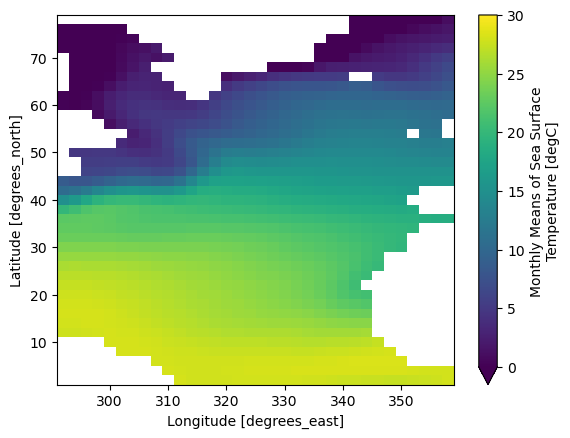

In [14]:
na(obs_sst.sel(time='2007').mean(dim='time')).plot(vmin=0, vmax=30)

In [15]:
na_model_ssta_dt = na(model_ssta_dt)
na_obs_ssta_dt = na(obs_ssta_dt)

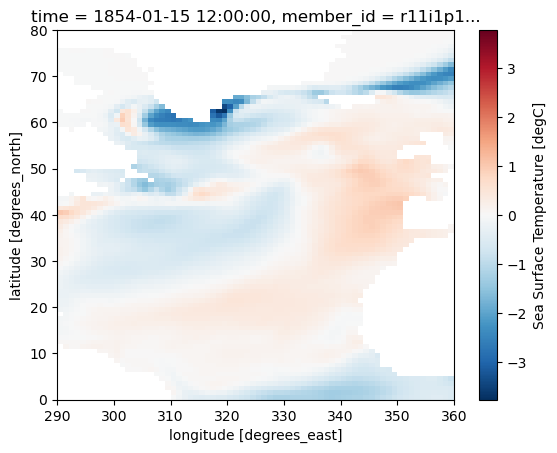

In [16]:
na_model_ssta_dt.isel(time=0, member_id=0).plot()

## Analysis of variability

### AMV index

Atlantic Multidecadal Variability is [usually defined as the average SST anomaly over the Atlantic basin 0-80N](https://climatedataguide.ucar.edu/climate-data/atlantic-multi-decadal-oscillation-amo). 

In [17]:
model_amv = global_average(na_model_ssta_dt)
model_amv_annual = model_amv.groupby('time.year').mean().load()
model_amv_std = np.std(model_amv.data)
model_amv_norm = model_amv/model_amv_std

obs_amv = global_average(na_obs_ssta_dt)
obs_amv_annual = obs_amv.groupby('time.year').mean().load()
obs_amv_std = np.std(obs_amv.data)
obs_amv_norm = obs_amv/obs_amv_std

In [18]:
model_amv_annual

<xarray.DataArray 'tos' (member_id: 10, year: 161)> Size: 13kB
array([[-0.14608895,  0.21623323,  0.09481922, ...,  0.09157032,
         0.20734082,  0.19188034],
       [ 0.04772001,  0.08638249,  0.16536116, ..., -0.16353617,
         0.15711757,  0.08279993],
       [-0.10423583, -0.1263847 , -0.02742207, ..., -0.00171421,
        -0.1562134 ,  0.33723081],
       ...,
       [ 0.08497816,  0.19208176,  0.04925919, ..., -0.01996483,
         0.07465725,  0.14331777],
       [-0.03616925,  0.1347251 ,  0.04524716, ...,  0.12951301,
         0.07812424,  0.10080975],
       [ 0.23961563,  0.15270012,  0.19635008, ...,  0.30018824,
         0.04408575,  0.10290637]])
Coordinates:
  * member_id  (member_id) object 80B 'r11i1p1f1' 'r1i1p1f1' ... 'r9i1p1f1'
  * year       (year) int64 1kB 1854 1855 1856 1857 1858 ... 2011 2012 2013 2014
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

CPU times: user 44.2 ms, sys: 1.07 ms, total: 45.3 ms
Wall time: 47.5 ms


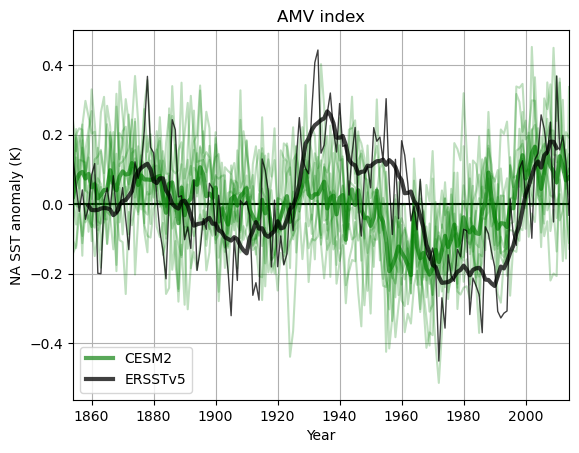

In [29]:
%%time
plt.hlines(0, 1850, 2015, color='k')
model_amv_annual.mean(dim='member_id').plot(label=model_name, color='forestgreen', linewidth=3, alpha=0.75)
for m in model_amv_annual.member_id:
    model_amv_annual.sel(member_id=m).plot(color='g', alpha=0.25)

obs_amv_annual.plot(color='k', linewidth=1, alpha=0.75)
obs_amv_annual.rolling(year=10, center=True).mean().plot(label='ERSSTv5', color='k', linewidth=3, alpha=0.75)

plt.ylabel('NA SST anomaly (K)')
plt.xlabel('Year')
plt.title('AMV index')
plt.legend()
plt.xlim(1854, 2014)
plt.grid()

## Additional analysis

These currently take too long to run.

### EOFs
We can also try running an EOF analysis on the NA region, which we can compare to the AMV index.

In [20]:
# %%time
# na_obs_eofa = eof_analysis(na_obs_ssta_dt.groupby('time.year').mean(), 4, dim='year')
# na_model_eofa = eof_analysis(na_model_ssta_dt.groupby('time.year').mean(), 4, dim='year')

In [21]:
# obs_eof1 = na_obs_eofa.components.sel(mode=1)
# model_eof1 = na_model_eofa.components.sel(mode=1)

In [22]:
# na_obs_eofa.components.plot.contourf(col='mode', levels=20)

In [23]:
# na_model_eofa.components.plot.contourf(col='mode', levels=20)

Since the EOF analysis does not capture the basin-wide SST variation characteristic of AMV, we will just compute and compare the spectra of the usual AMV index.

### Spectral analysis

In [24]:
# mod_f, mod_P = signal.periodogram(model_amv_norm)
# obs_f, obs_P = signal.periodogram(obs_amv_norm)

In [25]:
# plt.plot(2*np.pi/mod_f/12, mod_P, label=model_name)
# plt.plot(2*np.pi/obs_f/12, obs_P, label='ERSSTv5')
# plt.xlabel('Years')
# plt.ylabel('Spectral power')
# plt.yscale('log')
# plt.xlim(1, 50)
# plt.gca().invert_xaxis()
# plt.ylim(1e-2, 1e2)
# plt.legend()
# plt.grid()